In [1]:
# Part 2 of presentation for Kariera IT conference in Wrocław, Poland (06-10-2018).
# Copyright: Szymon Moliński, Data Lions

## Sentinel 2: pixel classification

In [2]:
%matplotlib inline

# Base packages
import itertools
import numpy as np
import pandas as pd
import rasterio as rio

from os import listdir

# Scikit-learn packages
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Data visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

from skimage.exposure import equalize_adapthist

In [3]:
# Function based on: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [4]:
data = pd.read_csv('classified_pixels.csv', sep=',', index_col=0)

In [5]:
data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,B11,B12,B8A,august,class,september,uws,uwt
0,1084.0,776,602,361,522.0,1507.0,1883.0,1930,554.0,6.0,825.0,332.0,2096.0,1,2,0,1,0
1,1084.0,776,595,369,527.0,1497.0,1855.0,1817,554.0,6.0,863.0,342.0,2112.0,1,2,0,1,0
2,1083.0,793,633,407,588.0,1569.0,1916.0,1987,552.0,6.0,1037.0,470.0,2183.0,1,2,0,1,0
3,1083.0,767,603,372,562.0,1535.0,1913.0,1893,552.0,6.0,1012.0,439.0,2221.0,1,2,0,1,0
4,1082.0,762,585,343,526.0,1477.0,1848.0,1757,546.0,6.0,823.0,353.0,2038.0,1,2,0,1,0


In [6]:
for column in data.columns[:-5]:
    print(column, data[column].mean(), data[column].min(), data[column].max())

B01 1312.9170924727841 928.0 7568.0
B02 1090.4139450693917 635 5910
B03 1042.9337231968811 409 6156
B04 936.3667631611328 222 6986
B05 1270.9937505261862 273.0 5392.0
B06 2327.0774643326663 330.0 5863.0
B07 2795.5810812561117 136.0 6332.0
B08 2710.9730916438384 320 7082
B09 792.0454527792349 79.0 4460.0
B10 14.297640095069715 2.0 133.0
B11 2234.5708975280577 95.0 7093.0
B12 1334.1723073834457 33.0 5894.0
B8A 3092.509056879926 243.0 6670.0


In [7]:
data.describe()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,B11,B12,B8A,august,class,september,uws,uwt
count,308826.000000,308826.000000,308826.000000,308826.000000,308826.000000,308826.000000,308826.000000,308826.000000,308826.000000,308826.000000,308826.000000,308826.000000,308826.000000,308826.000000,308826.000000,308826.000000,308826.000000,308826.000000
mean,1312.917092,1090.413945,1042.933723,936.366763,1270.993751,2327.077464,2795.581081,2710.973092,792.045453,14.297640,2234.570898,1334.172307,3092.509057,0.720153,0.033090,0.279847,0.720153,0.279847
std,207.104634,222.388842,233.530745,428.441840,368.955183,622.925191,814.315737,814.540256,264.201505,13.226178,699.523390,645.136811,870.468120,0.448925,0.225321,0.448925,0.448925,0.448925
min,928.000000,635.000000,409.000000,222.000000,273.000000,330.000000,136.000000,320.000000,79.000000,2.000000,95.000000,33.000000,243.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1142.000000,881.000000,868.000000,578.000000,1026.000000,1925.000000,2224.000000,2133.000000,591.000000,10.000000,1789.000000,832.000000,2477.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1285.000000,1109.000000,1046.000000,844.000000,1234.000000,2232.000000,2643.000000,2579.000000,796.000000,11.000000,2195.000000,1151.000000,2975.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1456.000000,1239.000000,1200.000000,1263.000000,1536.000000,2605.000000,3277.000000,3210.000000,972.000000,13.000000,2667.000000,1876.000000,3635.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,7568.000000,5910.000000,6156.000000,6986.000000,5392.000000,5863.000000,6332.000000,7082.000000,4460.000000,133.000000,7093.000000,5894.000000,6670.000000,1.000000,2.000000,1.000000,1.000000,1.000000


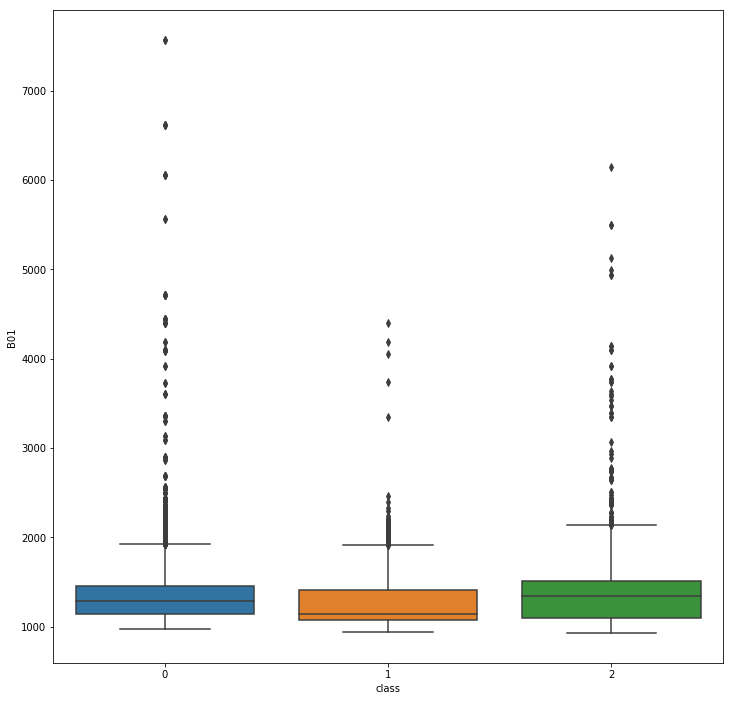

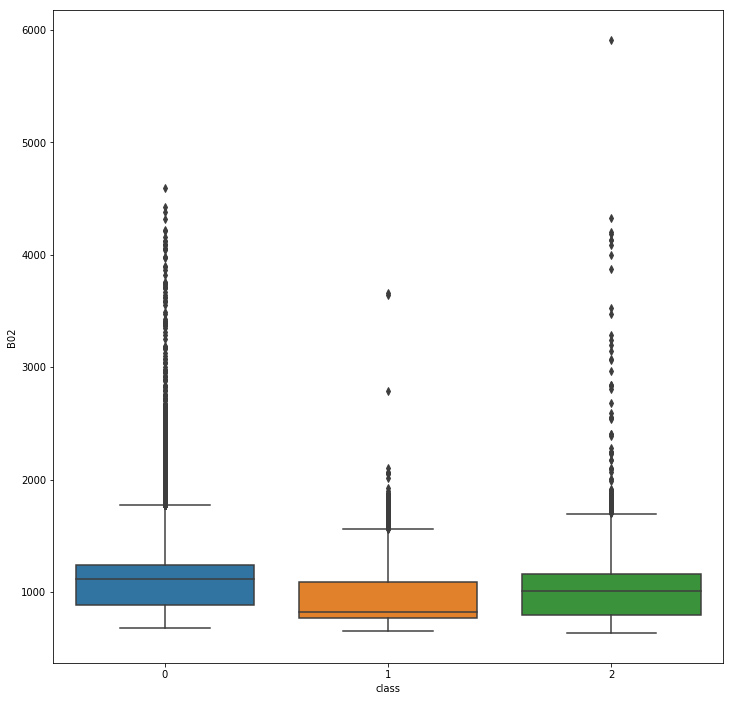

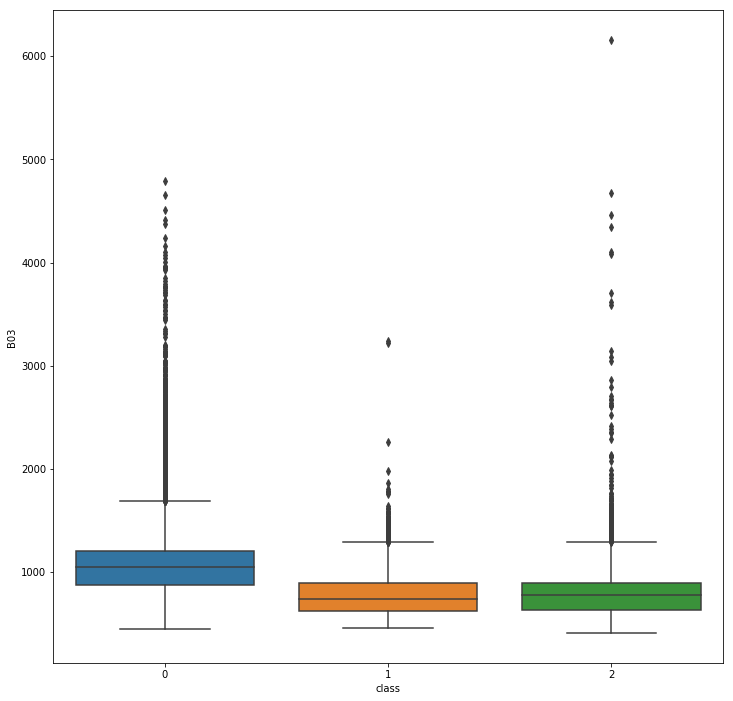

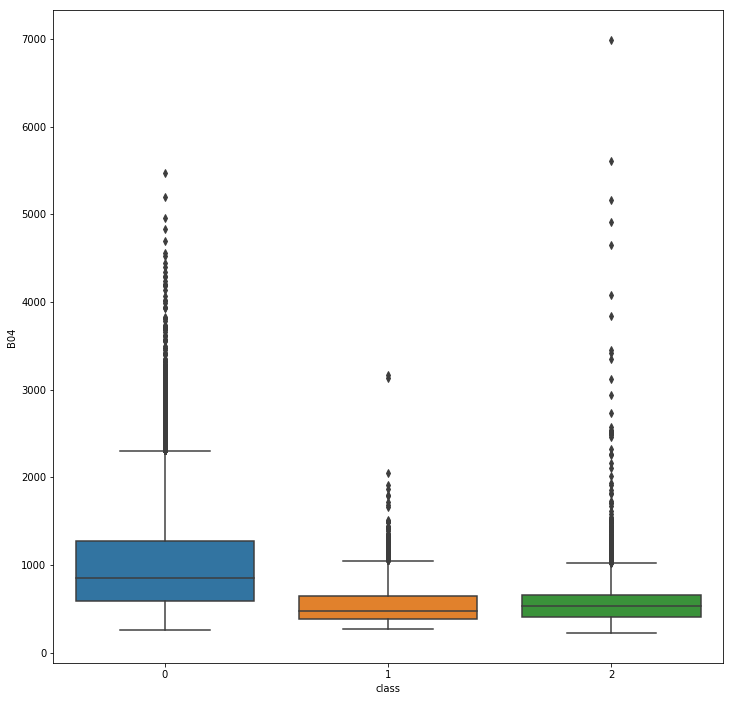

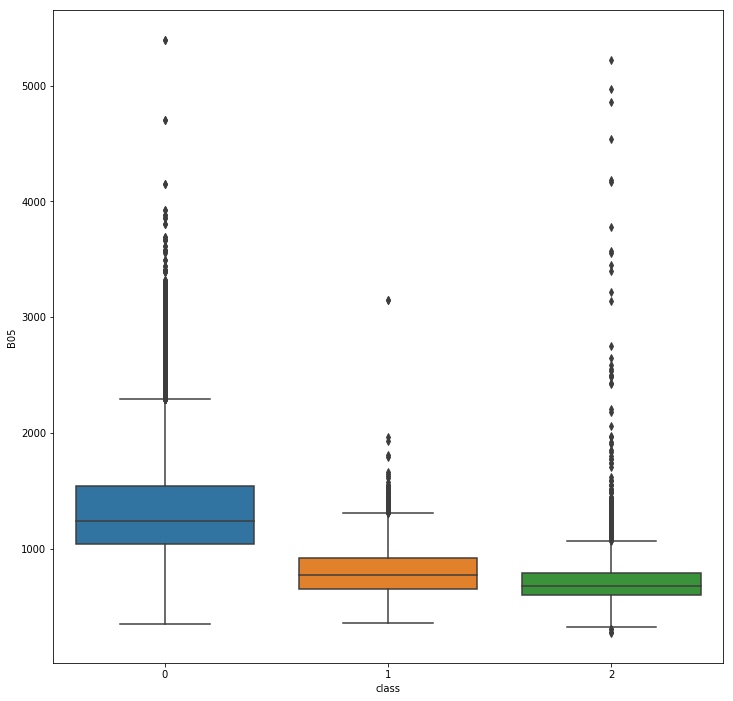

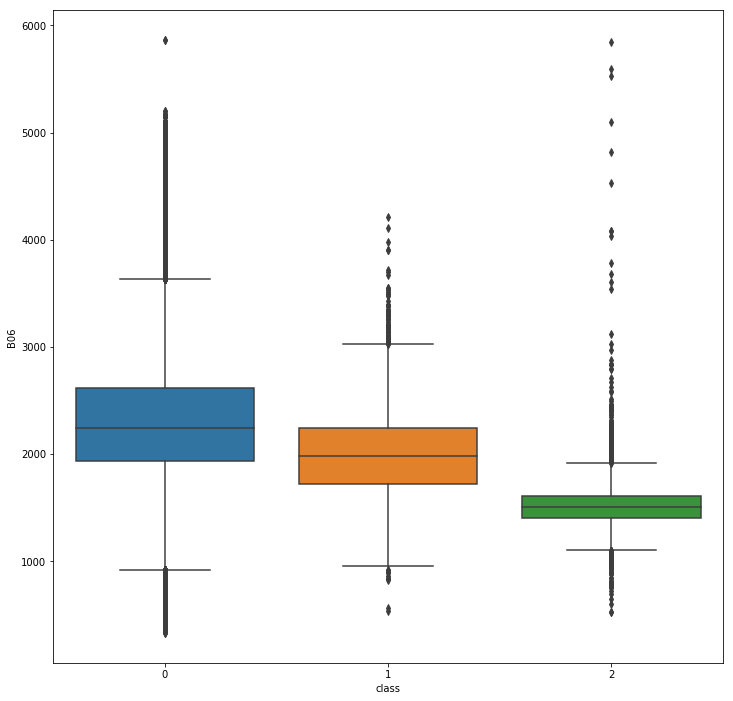

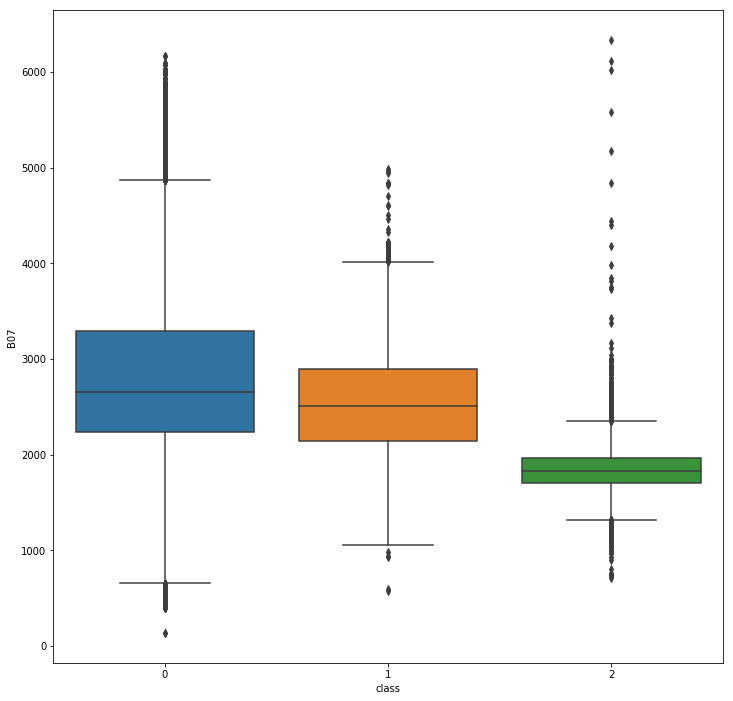

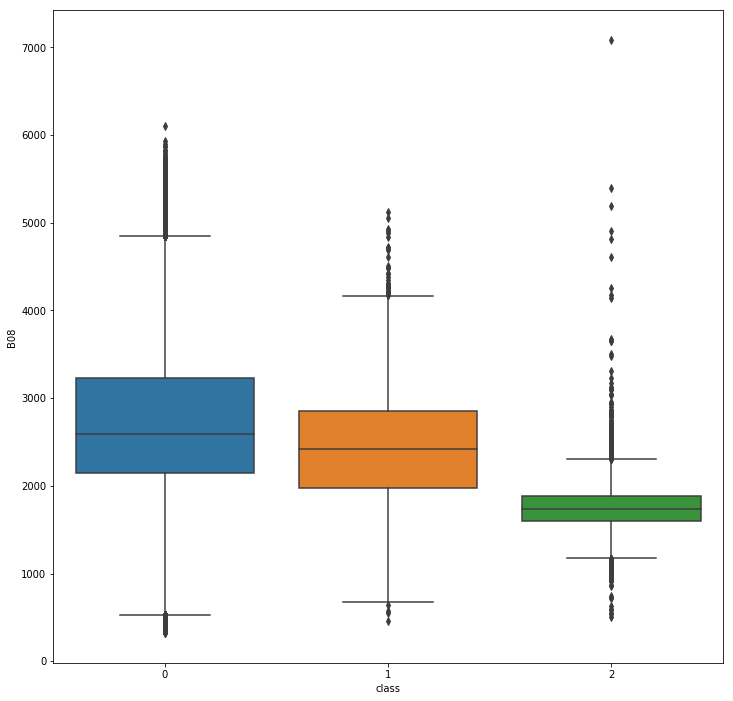

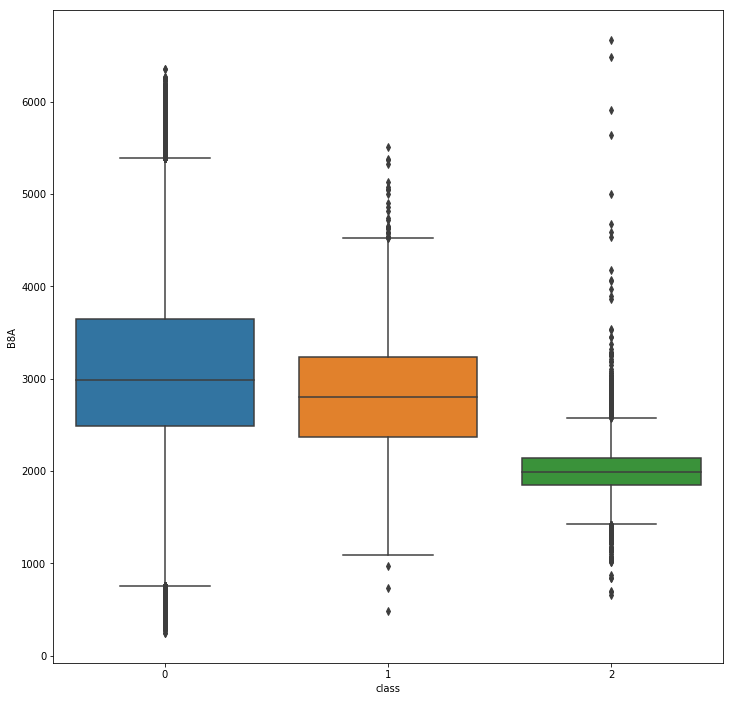

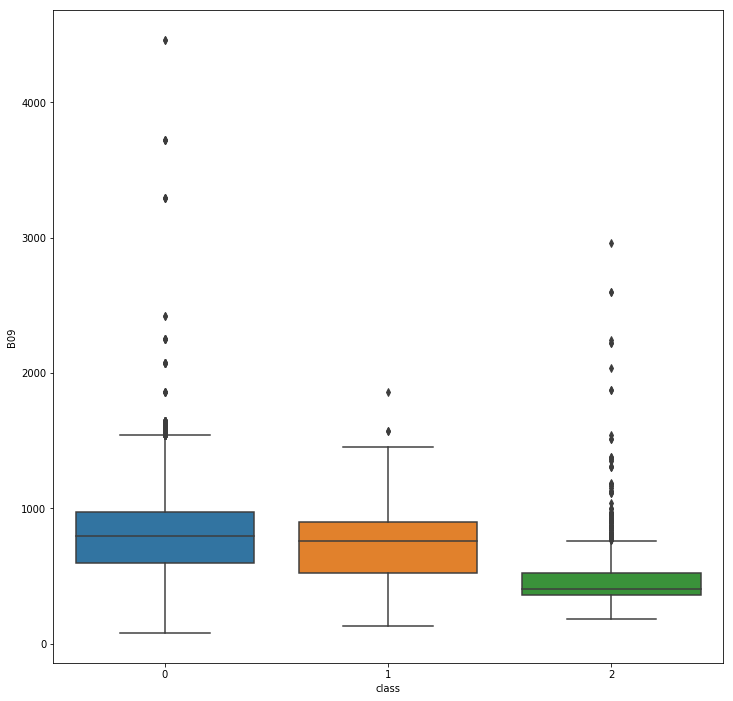

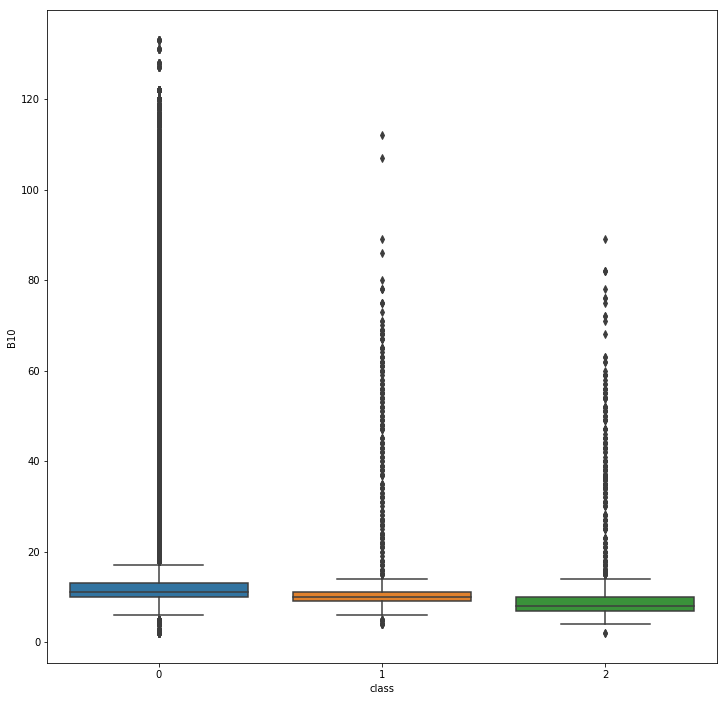

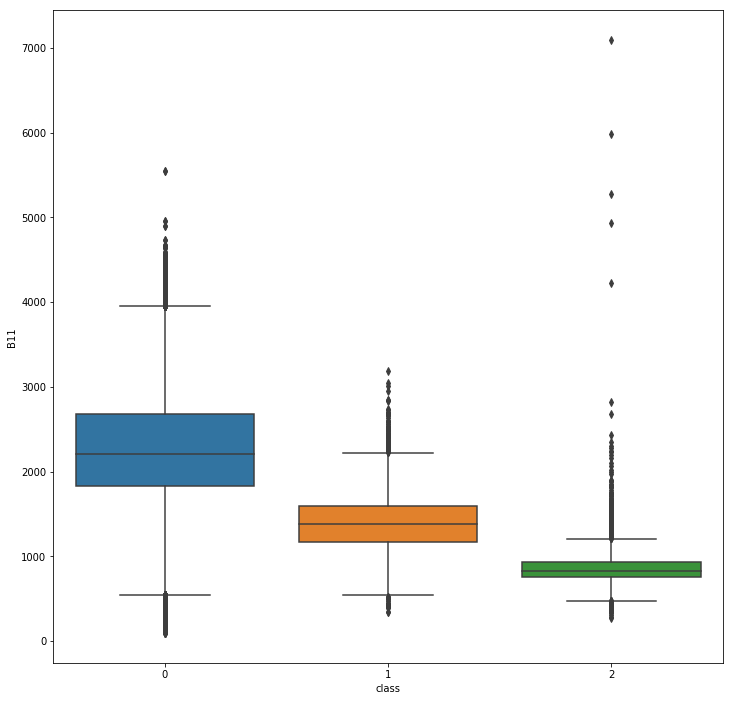

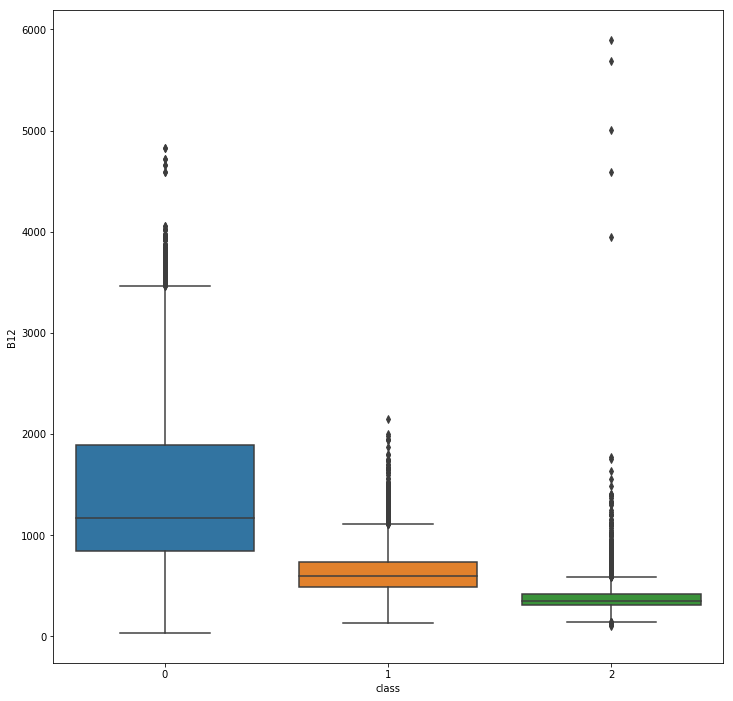

In [8]:
band_cols = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']

for x in band_cols:
    plt.figure(figsize=(12, 12))
    sns.boxplot(x='class', y=x, data=data)

Confusion matrix, without normalization
[[74568   686    97]
 [  770   300    52]
 [  108    63   563]]
Normalized confusion matrix
[[0.98960863 0.00910406 0.00128731]
 [0.68627451 0.26737968 0.04634581]
 [0.14713896 0.08583106 0.76702997]]
Accuracy score is: 0.9769969044257645
Precision: 0.6883598428262667, Recall: 0.6746727611668405, F1 score: 0.6813517966503643


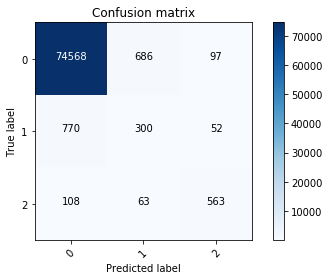

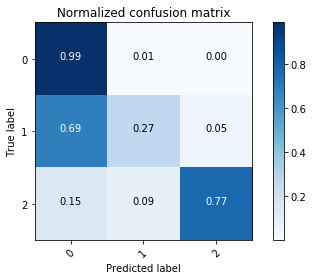

In [9]:
# Classification task: Descision Tree, Random Forest, NN, AdaBoost and Naive Bayes

def scale_data(dataset):
    scaler = StandardScaler()
    scaler.fit(dataset)
    transformed_data = scaler.transform(dataset)
    return transformed_data, scaler

decision_tree_classifier = DecisionTreeClassifier(criterion='entropy', 
                                                  max_depth=25, 
                                                  min_samples_split=3, 
                                                  random_state=0)
training_data_X, scaler = scale_data(data.drop(['class'], axis=1))
training_data_Y = data['class']
X_train, X_test, y_train, y_test = train_test_split(training_data_X, training_data_Y, random_state=0)
decision_tree_classifier.fit(X_train, y_train)

# Predictions on a test set

predictions = decision_tree_classifier.predict(X_test)
output = accuracy_score(y_test, predictions)
confusion_mtx = confusion_matrix(y_test, predictions)

plt.figure()
plot_confusion_matrix(confusion_mtx, classes=[0, 1, 2], normalize=False,
                      title='Confusion matrix')
plt.figure()
plot_confusion_matrix(confusion_mtx, classes=[0, 1, 2], normalize=True,
                      title='Normalized confusion matrix')
print('Accuracy score is:', output)
p_r_f1 = precision_recall_fscore_support(y_test, predictions, average='macro')
print('Precision: {}, Recall: {}, F1 score: {}'.format(p_r_f1[0], p_r_f1[1], p_r_f1[2]))

Confusion matrix, without normalization
[[74587   681    83]
 [  758   312    52]
 [  117    66   551]]
Normalized confusion matrix
[[0.98986078 0.0090377  0.00110151]
 [0.67557932 0.27807487 0.04634581]
 [0.15940054 0.08991826 0.7506812 ]]
Accuracy score is: 0.9772429961013898
Precision: 0.6954097736118622, Recall: 0.6728722833601433, F1 score: 0.6837652882909696


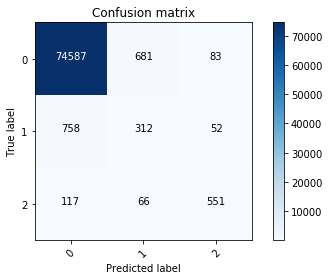

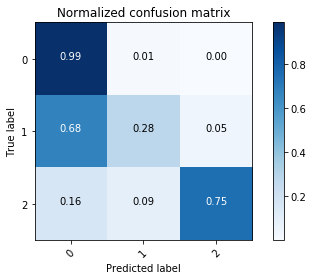

In [10]:
# Decision tree classifier - gini criterion

decision_tree_classifier = DecisionTreeClassifier(criterion='gini', 
                                                  max_depth=25, 
                                                  min_samples_split=3, 
                                                  random_state=0)

decision_tree_classifier.fit(X_train, y_train)

# Predictions on a test set

predictions = decision_tree_classifier.predict(X_test)
output = accuracy_score(y_test, predictions)

confusion_mtx = confusion_matrix(y_test, predictions)
plt.figure()
plot_confusion_matrix(confusion_mtx, classes=[0, 1, 2], normalize=False,
                      title='Confusion matrix')
plt.figure()
plot_confusion_matrix(confusion_mtx, classes=[0, 1, 2], normalize=True,
                      title='Normalized confusion matrix')
print('Accuracy score is:', output)
p_r_f1 = precision_recall_fscore_support(y_test, predictions, average='macro')
print('Precision: {}, Recall: {}, F1 score: {}'.format(p_r_f1[0], p_r_f1[1], p_r_f1[2]))

Confusion matrix, without normalization
[[75191   130    30]
 [  883   191    48]
 [  129    27   578]]
Normalized confusion matrix
[[9.97876604e-01 1.72525912e-03 3.98136720e-04]
 [7.86987522e-01 1.70231729e-01 4.27807487e-02]
 [1.75749319e-01 3.67847411e-02 7.87465940e-01]]
Accuracy score is: 0.9838486147629101
Precision: 0.8055559395467894, Recall: 0.651858091089652, F1 score: 0.6945951348780383


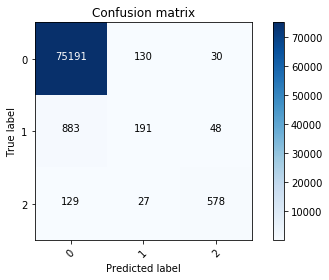

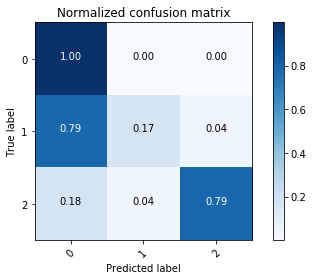

In [11]:
# Random Forest

random_forest_classifier = RandomForestClassifier().fit(X_train, y_train)
predictions = random_forest_classifier.predict(X_test)
output = accuracy_score(y_test, predictions)
confusion_mtx = confusion_matrix(y_test, predictions)
plt.figure()
plot_confusion_matrix(confusion_mtx, classes=[0, 1, 2], normalize=False,
                      title='Confusion matrix')
plt.figure()
plot_confusion_matrix(confusion_mtx, classes=[0, 1, 2], normalize=True,
                      title='Normalized confusion matrix')
print('Accuracy score is:', output)
p_r_f1 = precision_recall_fscore_support(y_test, predictions, average='macro')
print('Precision: {}, Recall: {}, F1 score: {}'.format(p_r_f1[0], p_r_f1[1], p_r_f1[2]))

Confusion matrix, without normalization
[[74915   331   105]
 [  748   305    69]
 [  106    11   617]]
Normalized confusion matrix
[[0.99421375 0.00439278 0.00139348]
 [0.66666667 0.27183601 0.06149733]
 [0.14441417 0.01498638 0.84059946]]
Accuracy score is: 0.9822554949680729
Precision: 0.7467202252104062, Recall: 0.7022164028349405, F1 score: 0.7151572171676531


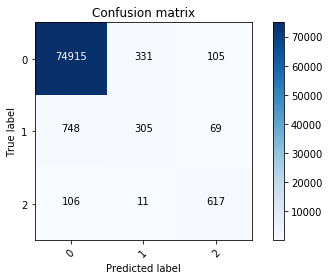

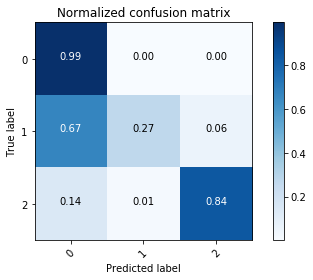

In [12]:
# Neural Network

nn_classifier = MLPClassifier(hidden_layer_sizes=(48, 48, 24, 12, 3))
nn_classifier.fit(X_train, y_train)
predictions = nn_classifier.predict(X_test)
output = accuracy_score(y_test, predictions)
confusion_mtx = confusion_matrix(y_test, predictions)
plt.figure()
plot_confusion_matrix(confusion_mtx, classes=[0, 1, 2], normalize=False,
                      title='Confusion matrix')
plt.figure()
plot_confusion_matrix(confusion_mtx, classes=[0, 1, 2], normalize=True,
                      title='Normalized confusion matrix')
print('Accuracy score is:', output)
p_r_f1 = precision_recall_fscore_support(y_test, predictions, average='macro')
print('Precision: {}, Recall: {}, F1 score: {}'.format(p_r_f1[0], p_r_f1[1], p_r_f1[2]))

Confusion matrix, without normalization
[[75098    80   173]
 [  931   117    74]
 [  196    22   516]]
Normalized confusion matrix
[[0.99664238 0.0010617  0.00229592]
 [0.82976827 0.10427807 0.06595365]
 [0.26702997 0.02997275 0.70299728]]
Accuracy score is: 0.9808825624619529
Precision: 0.7319130834882922, Recall: 0.6013059101324693, F1 score: 0.6182570193715867


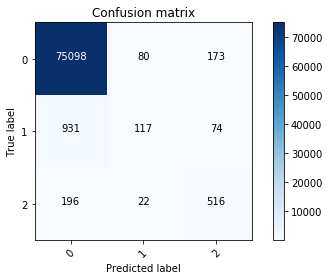

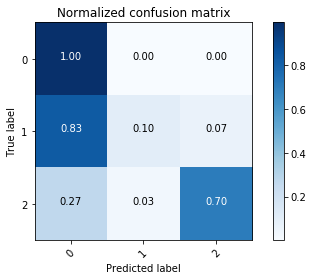

In [13]:
# AdaBoost

adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(X_train, y_train)
predictions = adaboost_classifier.predict(X_test)
output = accuracy_score(y_test, predictions)
confusion_mtx = confusion_matrix(y_test, predictions)
plt.figure()
plot_confusion_matrix(confusion_mtx, classes=[0, 1, 2], normalize=False,
                      title='Confusion matrix')
plt.figure()
plot_confusion_matrix(confusion_mtx, classes=[0, 1, 2], normalize=True,
                      title='Normalized confusion matrix')
print('Accuracy score is:', output)
p_r_f1 = precision_recall_fscore_support(y_test, predictions, average='macro')
print('Precision: {}, Recall: {}, F1 score: {}'.format(p_r_f1[0], p_r_f1[1], p_r_f1[2]))

Confusion matrix, without normalization
[[64189  7220  3942]
 [  235   672   215]
 [   10    54   670]]
Normalized confusion matrix
[[0.8518666  0.09581824 0.05231517]
 [0.20944742 0.59893048 0.1916221 ]
 [0.01362398 0.07356948 0.91280654]]
Accuracy score is: 0.8487701892315463
Precision: 0.40652369392118776, Recall: 0.7878678728164203, F1 score: 0.4358578205819578


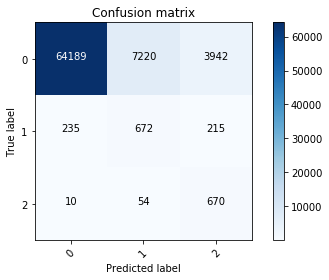

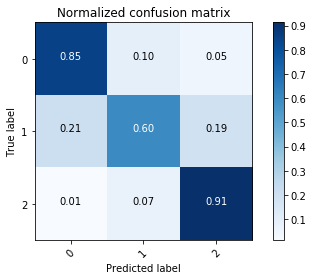

In [14]:
# Naive Bayes

nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
predictions = nb_classifier.predict(X_test)
output = accuracy_score(y_test, predictions)
confusion_mtx = confusion_matrix(y_test, predictions)
plt.figure()
plot_confusion_matrix(confusion_mtx, classes=[0, 1, 2], normalize=False,
                      title='Confusion matrix')
plt.figure()
plot_confusion_matrix(confusion_mtx, classes=[0, 1, 2], normalize=True,
                      title='Normalized confusion matrix')
print('Accuracy score is:', output)
p_r_f1 = precision_recall_fscore_support(y_test, predictions, average='macro')
print('Precision: {}, Recall: {}, F1 score: {}'.format(p_r_f1[0], p_r_f1[1], p_r_f1[2]))

/home/datalions/miniconda3/envs/l8p/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


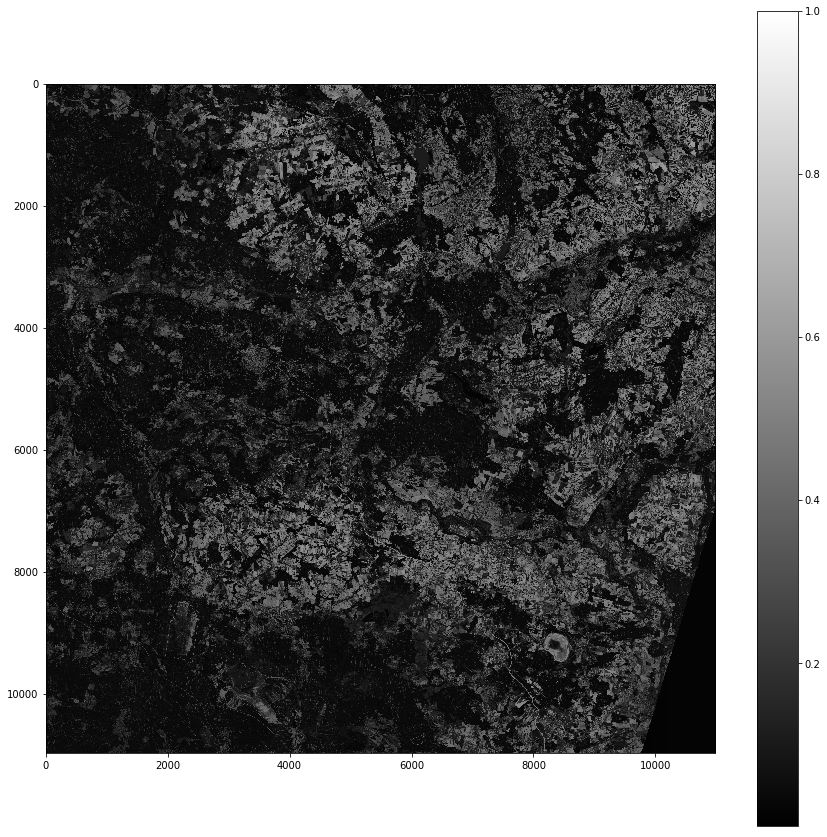

Sentinel 2 scene crs: 
CRS({'init': 'epsg:32633'}), 
and Sentinel 2 scene transform: 
| 10.00, 0.00, 499980.00|
| 0.00,-10.00, 5800020.00|
| 0.00, 0.00, 1.00|


In [15]:
# From this point we will analyze real-world data and visualize Error of it.
# We will use NN model.

# 1. Read base data and show it

def show_band(band, color_map='gray'):
    try:
        band[band == 0] = np.nan
    except ValueError:
        band = band.astype(float)
        band[band == 0] = np.nan
    plt.figure(figsize=(15,15))
    plt.imshow(band, cmap=color_map)
    plt.colorbar()
    plt.show()
    
def equalize(image):
    image = image.astype(float)
    image = image / np.max(image)
    image[image < 0] = 0
    image[:, :] = equalize_adapthist(image[:, :], clip_limit=0.02)
    return image
    
base_image = 'S2A_MSIL2A_20160827T101022_N0204_R022_T33UWT_20160827T101025.SAFE/GRANULE/L2A_T33UWT_A006168_20160827T101025/IMG_DATA/R10m/L2A_T33UWT_20160827T101022_B04_10m.jp2'
with rio.open(base_image, 'r') as scene:
    base_band = scene.read(1)
    base_crs = scene.crs
    base_transform = scene.transform
    
show_band(equalize(base_band))
print('Sentinel 2 scene crs: \n{}, \nand Sentinel 2 scene transform: \n{}'.format(base_crs, base_transform))

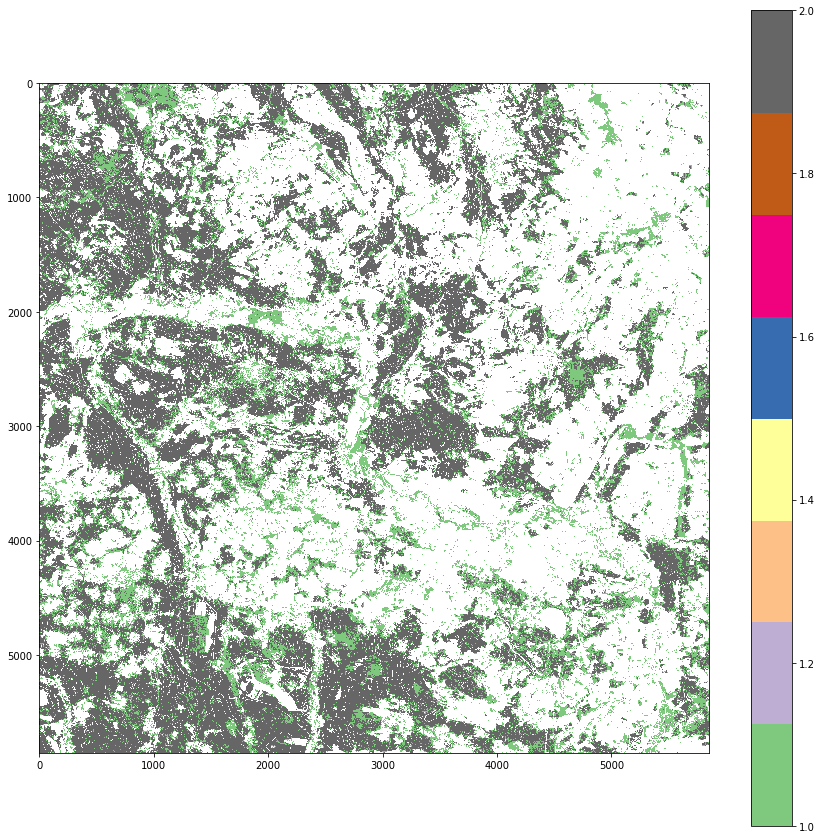

Forest Type crs: 
CRS({'proj': 'laea', 'lat_0': 52, 'lon_0': 10, 'x_0': 4321000, 'y_0': 3210000, 'ellps': 'GRS80', 'units': 'm', 'no_defs': True}), 
and Forest Type transform: 
| 20.00, 0.00, 4661360.00|
| 0.00,-20.00, 3268240.00|
| 0.00, 0.00, 1.00|


In [16]:
classified_forests = 'ftycut2.tif'
with rio.open(classified_forests, 'r') as cf:
    cf_band = cf.read(1)
    cf_crs = cf.crs
    cf_transform = cf.transform
    
show_band(cf_band, color_map='Accent')
print('Forest Type crs: \n{}, \nand Forest Type transform: \n{}'.format(cf_crs, cf_transform))

In [17]:
# Raster must be reprojected to prepare input data
from rasterio.warp import reproject, Resampling  # Don't do this! Avoid importing libraries inside the code.

def reproject_raster(reprojected_band, reprojected_transform, reprojected_crs,
                    height, width, reprojecting_transform, reprojecting_crs):
    
    destination = np.zeros((height, width))
    reproject(
        reprojected_band,
        destination,
        src_transform=reprojected_transform,
        src_crs=reprojected_crs,
        dst_transform=reprojecting_transform,
        dst_crs=reprojecting_crs,
        resampling=Resampling.med)
    return destination

values_for_reprojection = [base_band.shape[0], base_band.shape[1], base_transform, base_crs]  # Sentinel 2 data

y_test = reproject_raster(cf_band, cf_transform, cf_crs,
                         values_for_reprojection[0], values_for_reprojection[1],
                         values_for_reprojection[2], values_for_reprojection[3])

In [18]:
# Rasters values prediction - NN model

directory_with_dataframes = 'dataframes/'
dataframes = listdir(directory_with_dataframes)
print('First element of a list:', dataframes[0])
print('Number of list elements:', len(dataframes))

First element of a list: unknown_pixels_row_3913.csv
Number of list elements: 10980


In [19]:
sample_df = pd.read_csv(directory_with_dataframes + dataframes[0], index_col='col')
sample_df.head()

,Unnamed: 0,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,B11,B12,B8A,august,september,uws,uwt
col,,,,,,,,,,,,,,,,,,
42964740,0,1088.0,753,557,325,531.0,1372.0,1866.0,1608,523.0,6.0,875.0,324.0,1873.0,1,0,0,1
42964741,1,1088.0,770,601,342,531.0,1372.0,1866.0,2319,523.0,6.0,875.0,324.0,1873.0,1,0,0,1
42964742,2,1088.0,789,580,346,522.0,1565.0,2094.0,2259,523.0,6.0,940.0,348.0,2376.0,1,0,0,1
42964743,3,1088.0,787,615,346,522.0,1565.0,2094.0,2430,523.0,6.0,940.0,348.0,2376.0,1,0,0,1
42964744,4,1088.0,762,545,341,492.0,1570.0,2037.0,2103,523.0,6.0,936.0,339.0,2400.0,1,0,0,1


In [20]:
sample_df.drop('Unnamed: 0', axis=1, inplace=True)
sample_df.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,B11,B12,B8A,august,september,uws,uwt
col,,,,,,,,,,,,,,,,,
42964740,1088.0,753,557,325,531.0,1372.0,1866.0,1608,523.0,6.0,875.0,324.0,1873.0,1,0,0,1
42964741,1088.0,770,601,342,531.0,1372.0,1866.0,2319,523.0,6.0,875.0,324.0,1873.0,1,0,0,1
42964742,1088.0,789,580,346,522.0,1565.0,2094.0,2259,523.0,6.0,940.0,348.0,2376.0,1,0,0,1
42964743,1088.0,787,615,346,522.0,1565.0,2094.0,2430,523.0,6.0,940.0,348.0,2376.0,1,0,0,1
42964744,1088.0,762,545,341,492.0,1570.0,2037.0,2103,523.0,6.0,936.0,339.0,2400.0,1,0,0,1


In [21]:
# Return first prediction as an example

for idx in sample_df.index:
    initial_values = sample_df[sample_df.index == idx]
    scaled_values = scaler.transform(initial_values)
    print('Scaled values:', scaled_values)
    prediction = nb_classifier.predict(scaled_values)
    print('Predicted class:', prediction)
    break

Scaled values: [[-1.08600881 -1.51722761 -2.080816   -1.42695623 -2.00564996 -1.53321623
  -1.14155056 -1.35410726 -1.01833594 -0.62736595 -1.9435706  -1.56582902
  -1.40098299  0.62337278 -0.62337278 -1.60417655  1.60417655]]
Predicted class: [2]


In [22]:
# Return first 100 rows of predictions (based on neural networks)

# Prepare "clear" matrix for output values
predicted_classes = np.zeros(shape=base_band.shape)

limit = 100  # should be len(dataframes)
i = 0
for dataframe in dataframes:
    print('Start of calculation')
    sample_df = pd.read_csv(directory_with_dataframes + dataframe, index_col='col')
    sample_df.drop('Unnamed: 0', axis=1, inplace=True)
    row = np.floor(sample_df.index[0] / len(dataframes))
    row = int(row)
    for idx in sample_df.index:
        col = idx - len(dataframes) * row
        initial_values = sample_df[sample_df.index == idx]
        if np.mean(initial_values.values[0][:6]) == 0:
            predicted_classes[row, col] = 3
        else:
            scaled_values = scaler.transform(initial_values)
            prediction = nn_classifier.predict(scaled_values)
            predicted_classes[row, col] = prediction[0]
    print('End of calculation of row number:', row)
    percent = format(i/limit * 100, '.2f')
    print(percent, '%')
    i = i + 1
    if i == limit:
        break
    
    

Start of calculation
End of calculation of row number: 3913
0.00 %
Start of calculation
End of calculation of row number: 0
1.00 %
Start of calculation
End of calculation of row number: 1
2.00 %
Start of calculation
End of calculation of row number: 10
3.00 %
Start of calculation
End of calculation of row number: 100
4.00 %
Start of calculation
End of calculation of row number: 1000
5.00 %
Start of calculation
End of calculation of row number: 10000
6.00 %
Start of calculation
End of calculation of row number: 10001
7.00 %
Start of calculation
End of calculation of row number: 10002
8.00 %
Start of calculation
End of calculation of row number: 10003
9.00 %
Start of calculation
End of calculation of row number: 10004
10.00 %
Start of calculation
End of calculation of row number: 10005
11.00 %
Start of calculation
End of calculation of row number: 10006
12.00 %
Start of calculation
End of calculation of row number: 10007
13.00 %
Start of calculation
End of calculation of row number: 1000

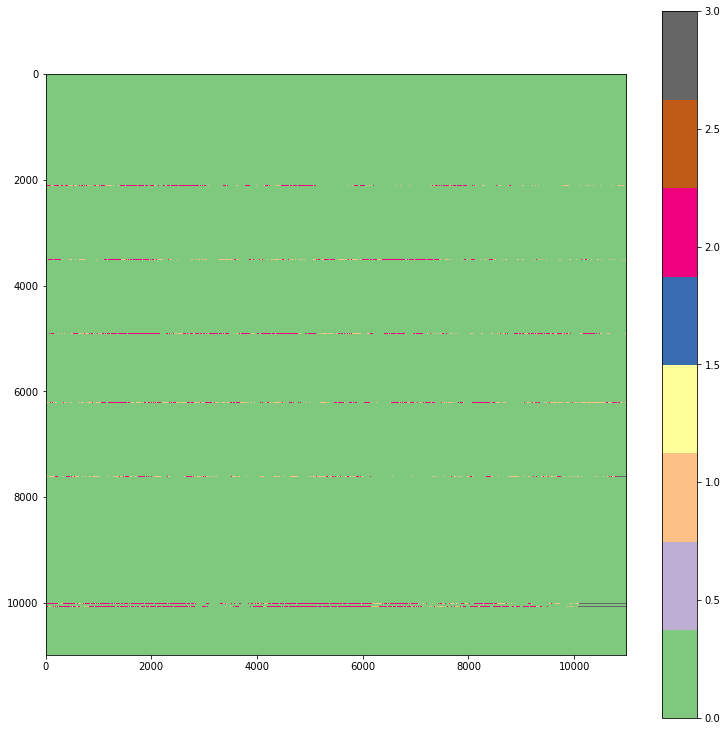

In [23]:
plt.figure(figsize=(13, 13))
plt.imshow(predicted_classes, cmap='Accent')
plt.colorbar()
plt.show()

In [24]:
# Calculate all rows

# Prepare "clear" matrix for output values
predicted_classes = np.zeros(shape=base_band.shape)
i = 0
for dataframe in dataframes:
    sample_df = pd.read_csv(directory_with_dataframes + dataframe, index_col='col')
    sample_df.drop('Unnamed: 0', axis=1, inplace=True)
    row = np.floor(sample_df.index[0] / len(dataframes))
    row = int(row)
    scaled_values = scaler.transform(sample_df)
    prediction = nn_classifier.predict(scaled_values)
    predicted_classes[row, :] = prediction
    percent = format(i/len(dataframes) * 100, '.3f')
    i = i + 1
    print(percent, '%')
print('100%')

0.000 %
0.009 %
0.018 %
0.027 %
0.036 %
0.046 %
0.055 %
0.064 %
0.073 %
0.082 %
0.091 %
0.100 %
0.109 %
0.118 %
0.128 %
0.137 %
0.146 %
0.155 %
0.164 %
0.173 %
0.182 %
0.191 %
0.200 %
0.209 %
0.219 %
0.228 %
0.237 %
0.246 %
0.255 %
0.264 %
0.273 %
0.282 %
0.291 %
0.301 %
0.310 %
0.319 %
0.328 %
0.337 %
0.346 %
0.355 %
0.364 %
0.373 %
0.383 %
0.392 %
0.401 %
0.410 %
0.419 %
0.428 %
0.437 %
0.446 %
0.455 %
0.464 %
0.474 %
0.483 %
0.492 %
0.501 %
0.510 %
0.519 %
0.528 %
0.537 %
0.546 %
0.556 %
0.565 %
0.574 %
0.583 %
0.592 %
0.601 %
0.610 %
0.619 %
0.628 %
0.638 %
0.647 %
0.656 %
0.665 %
0.674 %
0.683 %
0.692 %
0.701 %
0.710 %
0.719 %
0.729 %
0.738 %
0.747 %
0.756 %
0.765 %
0.774 %
0.783 %
0.792 %
0.801 %
0.811 %
0.820 %
0.829 %
0.838 %
0.847 %
0.856 %
0.865 %
0.874 %
0.883 %
0.893 %
0.902 %
0.911 %
0.920 %
0.929 %
0.938 %
0.947 %
0.956 %
0.965 %
0.974 %
0.984 %
0.993 %
1.002 %
1.011 %
1.020 %
1.029 %
1.038 %
1.047 %
1.056 %
1.066 %
1.075 %
1.084 %
1.093 %
1.102 %
1.111 %
1.120 %
1.129 %


9.362 %
9.372 %
9.381 %
9.390 %
9.399 %
9.408 %
9.417 %
9.426 %
9.435 %
9.444 %
9.454 %
9.463 %
9.472 %
9.481 %
9.490 %
9.499 %
9.508 %
9.517 %
9.526 %
9.536 %
9.545 %
9.554 %
9.563 %
9.572 %
9.581 %
9.590 %
9.599 %
9.608 %
9.617 %
9.627 %
9.636 %
9.645 %
9.654 %
9.663 %
9.672 %
9.681 %
9.690 %
9.699 %
9.709 %
9.718 %
9.727 %
9.736 %
9.745 %
9.754 %
9.763 %
9.772 %
9.781 %
9.791 %
9.800 %
9.809 %
9.818 %
9.827 %
9.836 %
9.845 %
9.854 %
9.863 %
9.872 %
9.882 %
9.891 %
9.900 %
9.909 %
9.918 %
9.927 %
9.936 %
9.945 %
9.954 %
9.964 %
9.973 %
9.982 %
9.991 %
10.000 %
10.009 %
10.018 %
10.027 %
10.036 %
10.046 %
10.055 %
10.064 %
10.073 %
10.082 %
10.091 %
10.100 %
10.109 %
10.118 %
10.128 %
10.137 %
10.146 %
10.155 %
10.164 %
10.173 %
10.182 %
10.191 %
10.200 %
10.209 %
10.219 %
10.228 %
10.237 %
10.246 %
10.255 %
10.264 %
10.273 %
10.282 %
10.291 %
10.301 %
10.310 %
10.319 %
10.328 %
10.337 %
10.346 %
10.355 %
10.364 %
10.373 %
10.383 %
10.392 %
10.401 %
10.410 %
10.419 %
10.428 %
10.437 %

17.760 %
17.769 %
17.778 %
17.787 %
17.796 %
17.805 %
17.814 %
17.823 %
17.832 %
17.842 %
17.851 %
17.860 %
17.869 %
17.878 %
17.887 %
17.896 %
17.905 %
17.914 %
17.923 %
17.933 %
17.942 %
17.951 %
17.960 %
17.969 %
17.978 %
17.987 %
17.996 %
18.005 %
18.015 %
18.024 %
18.033 %
18.042 %
18.051 %
18.060 %
18.069 %
18.078 %
18.087 %
18.097 %
18.106 %
18.115 %
18.124 %
18.133 %
18.142 %
18.151 %
18.160 %
18.169 %
18.179 %
18.188 %
18.197 %
18.206 %
18.215 %
18.224 %
18.233 %
18.242 %
18.251 %
18.260 %
18.270 %
18.279 %
18.288 %
18.297 %
18.306 %
18.315 %
18.324 %
18.333 %
18.342 %
18.352 %
18.361 %
18.370 %
18.379 %
18.388 %
18.397 %
18.406 %
18.415 %
18.424 %
18.434 %
18.443 %
18.452 %
18.461 %
18.470 %
18.479 %
18.488 %
18.497 %
18.506 %
18.515 %
18.525 %
18.534 %
18.543 %
18.552 %
18.561 %
18.570 %
18.579 %
18.588 %
18.597 %
18.607 %
18.616 %
18.625 %
18.634 %
18.643 %
18.652 %
18.661 %
18.670 %
18.679 %
18.689 %
18.698 %
18.707 %
18.716 %
18.725 %
18.734 %
18.743 %
18.752 %
18.761 %
1

26.066 %
26.075 %
26.084 %
26.093 %
26.102 %
26.111 %
26.120 %
26.129 %
26.138 %
26.148 %
26.157 %
26.166 %
26.175 %
26.184 %
26.193 %
26.202 %
26.211 %
26.220 %
26.230 %
26.239 %
26.248 %
26.257 %
26.266 %
26.275 %
26.284 %
26.293 %
26.302 %
26.311 %
26.321 %
26.330 %
26.339 %
26.348 %
26.357 %
26.366 %
26.375 %
26.384 %
26.393 %
26.403 %
26.412 %
26.421 %
26.430 %
26.439 %
26.448 %
26.457 %
26.466 %
26.475 %
26.485 %
26.494 %
26.503 %
26.512 %
26.521 %
26.530 %
26.539 %
26.548 %
26.557 %
26.566 %
26.576 %
26.585 %
26.594 %
26.603 %
26.612 %
26.621 %
26.630 %
26.639 %
26.648 %
26.658 %
26.667 %
26.676 %
26.685 %
26.694 %
26.703 %
26.712 %
26.721 %
26.730 %
26.740 %
26.749 %
26.758 %
26.767 %
26.776 %
26.785 %
26.794 %
26.803 %
26.812 %
26.821 %
26.831 %
26.840 %
26.849 %
26.858 %
26.867 %
26.876 %
26.885 %
26.894 %
26.903 %
26.913 %
26.922 %
26.931 %
26.940 %
26.949 %
26.958 %
26.967 %
26.976 %
26.985 %
26.995 %
27.004 %
27.013 %
27.022 %
27.031 %
27.040 %
27.049 %
27.058 %
27.067 %
2

34.390 %
34.399 %
34.408 %
34.417 %
34.426 %
34.435 %
34.444 %
34.454 %
34.463 %
34.472 %
34.481 %
34.490 %
34.499 %
34.508 %
34.517 %
34.526 %
34.536 %
34.545 %
34.554 %
34.563 %
34.572 %
34.581 %
34.590 %
34.599 %
34.608 %
34.617 %
34.627 %
34.636 %
34.645 %
34.654 %
34.663 %
34.672 %
34.681 %
34.690 %
34.699 %
34.709 %
34.718 %
34.727 %
34.736 %
34.745 %
34.754 %
34.763 %
34.772 %
34.781 %
34.791 %
34.800 %
34.809 %
34.818 %
34.827 %
34.836 %
34.845 %
34.854 %
34.863 %
34.872 %
34.882 %
34.891 %
34.900 %
34.909 %
34.918 %
34.927 %
34.936 %
34.945 %
34.954 %
34.964 %
34.973 %
34.982 %
34.991 %
35.000 %
35.009 %
35.018 %
35.027 %
35.036 %
35.046 %
35.055 %
35.064 %
35.073 %
35.082 %
35.091 %
35.100 %
35.109 %
35.118 %
35.128 %
35.137 %
35.146 %
35.155 %
35.164 %
35.173 %
35.182 %
35.191 %
35.200 %
35.209 %
35.219 %
35.228 %
35.237 %
35.246 %
35.255 %
35.264 %
35.273 %
35.282 %
35.291 %
35.301 %
35.310 %
35.319 %
35.328 %
35.337 %
35.346 %
35.355 %
35.364 %
35.373 %
35.383 %
35.392 %
3

42.705 %
42.714 %
42.723 %
42.732 %
42.741 %
42.750 %
42.760 %
42.769 %
42.778 %
42.787 %
42.796 %
42.805 %
42.814 %
42.823 %
42.832 %
42.842 %
42.851 %
42.860 %
42.869 %
42.878 %
42.887 %
42.896 %
42.905 %
42.914 %
42.923 %
42.933 %
42.942 %
42.951 %
42.960 %
42.969 %
42.978 %
42.987 %
42.996 %
43.005 %
43.015 %
43.024 %
43.033 %
43.042 %
43.051 %
43.060 %
43.069 %
43.078 %
43.087 %
43.097 %
43.106 %
43.115 %
43.124 %
43.133 %
43.142 %
43.151 %
43.160 %
43.169 %
43.179 %
43.188 %
43.197 %
43.206 %
43.215 %
43.224 %
43.233 %
43.242 %
43.251 %
43.260 %
43.270 %
43.279 %
43.288 %
43.297 %
43.306 %
43.315 %
43.324 %
43.333 %
43.342 %
43.352 %
43.361 %
43.370 %
43.379 %
43.388 %
43.397 %
43.406 %
43.415 %
43.424 %
43.434 %
43.443 %
43.452 %
43.461 %
43.470 %
43.479 %
43.488 %
43.497 %
43.506 %
43.515 %
43.525 %
43.534 %
43.543 %
43.552 %
43.561 %
43.570 %
43.579 %
43.588 %
43.597 %
43.607 %
43.616 %
43.625 %
43.634 %
43.643 %
43.652 %
43.661 %
43.670 %
43.679 %
43.689 %
43.698 %
43.707 %
4

51.029 %
51.038 %
51.047 %
51.056 %
51.066 %
51.075 %
51.084 %
51.093 %
51.102 %
51.111 %
51.120 %
51.129 %
51.138 %
51.148 %
51.157 %
51.166 %
51.175 %
51.184 %
51.193 %
51.202 %
51.211 %
51.220 %
51.230 %
51.239 %
51.248 %
51.257 %
51.266 %
51.275 %
51.284 %
51.293 %
51.302 %
51.311 %
51.321 %
51.330 %
51.339 %
51.348 %
51.357 %
51.366 %
51.375 %
51.384 %
51.393 %
51.403 %
51.412 %
51.421 %
51.430 %
51.439 %
51.448 %
51.457 %
51.466 %
51.475 %
51.485 %
51.494 %
51.503 %
51.512 %
51.521 %
51.530 %
51.539 %
51.548 %
51.557 %
51.566 %
51.576 %
51.585 %
51.594 %
51.603 %
51.612 %
51.621 %
51.630 %
51.639 %
51.648 %
51.658 %
51.667 %
51.676 %
51.685 %
51.694 %
51.703 %
51.712 %
51.721 %
51.730 %
51.740 %
51.749 %
51.758 %
51.767 %
51.776 %
51.785 %
51.794 %
51.803 %
51.812 %
51.821 %
51.831 %
51.840 %
51.849 %
51.858 %
51.867 %
51.876 %
51.885 %
51.894 %
51.903 %
51.913 %
51.922 %
51.931 %
51.940 %
51.949 %
51.958 %
51.967 %
51.976 %
51.985 %
51.995 %
52.004 %
52.013 %
52.022 %
52.031 %
5

59.326 %
59.335 %
59.344 %
59.353 %
59.362 %
59.372 %
59.381 %
59.390 %
59.399 %
59.408 %
59.417 %
59.426 %
59.435 %
59.444 %
59.454 %
59.463 %
59.472 %
59.481 %
59.490 %
59.499 %
59.508 %
59.517 %
59.526 %
59.536 %
59.545 %
59.554 %
59.563 %
59.572 %
59.581 %
59.590 %
59.599 %
59.608 %
59.617 %
59.627 %
59.636 %
59.645 %
59.654 %
59.663 %
59.672 %
59.681 %
59.690 %
59.699 %
59.709 %
59.718 %
59.727 %
59.736 %
59.745 %
59.754 %
59.763 %
59.772 %
59.781 %
59.791 %
59.800 %
59.809 %
59.818 %
59.827 %
59.836 %
59.845 %
59.854 %
59.863 %
59.872 %
59.882 %
59.891 %
59.900 %
59.909 %
59.918 %
59.927 %
59.936 %
59.945 %
59.954 %
59.964 %
59.973 %
59.982 %
59.991 %
60.000 %
60.009 %
60.018 %
60.027 %
60.036 %
60.046 %
60.055 %
60.064 %
60.073 %
60.082 %
60.091 %
60.100 %
60.109 %
60.118 %
60.128 %
60.137 %
60.146 %
60.155 %
60.164 %
60.173 %
60.182 %
60.191 %
60.200 %
60.209 %
60.219 %
60.228 %
60.237 %
60.246 %
60.255 %
60.264 %
60.273 %
60.282 %
60.291 %
60.301 %
60.310 %
60.319 %
60.328 %
6

67.659 %
67.668 %
67.678 %
67.687 %
67.696 %
67.705 %
67.714 %
67.723 %
67.732 %
67.741 %
67.750 %
67.760 %
67.769 %
67.778 %
67.787 %
67.796 %
67.805 %
67.814 %
67.823 %
67.832 %
67.842 %
67.851 %
67.860 %
67.869 %
67.878 %
67.887 %
67.896 %
67.905 %
67.914 %
67.923 %
67.933 %
67.942 %
67.951 %
67.960 %
67.969 %
67.978 %
67.987 %
67.996 %
68.005 %
68.015 %
68.024 %
68.033 %
68.042 %
68.051 %
68.060 %
68.069 %
68.078 %
68.087 %
68.097 %
68.106 %
68.115 %
68.124 %
68.133 %
68.142 %
68.151 %
68.160 %
68.169 %
68.179 %
68.188 %
68.197 %
68.206 %
68.215 %
68.224 %
68.233 %
68.242 %
68.251 %
68.260 %
68.270 %
68.279 %
68.288 %
68.297 %
68.306 %
68.315 %
68.324 %
68.333 %
68.342 %
68.352 %
68.361 %
68.370 %
68.379 %
68.388 %
68.397 %
68.406 %
68.415 %
68.424 %
68.434 %
68.443 %
68.452 %
68.461 %
68.470 %
68.479 %
68.488 %
68.497 %
68.506 %
68.515 %
68.525 %
68.534 %
68.543 %
68.552 %
68.561 %
68.570 %
68.579 %
68.588 %
68.597 %
68.607 %
68.616 %
68.625 %
68.634 %
68.643 %
68.652 %
68.661 %
6

75.984 %
75.993 %
76.002 %
76.011 %
76.020 %
76.029 %
76.038 %
76.047 %
76.056 %
76.066 %
76.075 %
76.084 %
76.093 %
76.102 %
76.111 %
76.120 %
76.129 %
76.138 %
76.148 %
76.157 %
76.166 %
76.175 %
76.184 %
76.193 %
76.202 %
76.211 %
76.220 %
76.230 %
76.239 %
76.248 %
76.257 %
76.266 %
76.275 %
76.284 %
76.293 %
76.302 %
76.311 %
76.321 %
76.330 %
76.339 %
76.348 %
76.357 %
76.366 %
76.375 %
76.384 %
76.393 %
76.403 %
76.412 %
76.421 %
76.430 %
76.439 %
76.448 %
76.457 %
76.466 %
76.475 %
76.485 %
76.494 %
76.503 %
76.512 %
76.521 %
76.530 %
76.539 %
76.548 %
76.557 %
76.566 %
76.576 %
76.585 %
76.594 %
76.603 %
76.612 %
76.621 %
76.630 %
76.639 %
76.648 %
76.658 %
76.667 %
76.676 %
76.685 %
76.694 %
76.703 %
76.712 %
76.721 %
76.730 %
76.740 %
76.749 %
76.758 %
76.767 %
76.776 %
76.785 %
76.794 %
76.803 %
76.812 %
76.821 %
76.831 %
76.840 %
76.849 %
76.858 %
76.867 %
76.876 %
76.885 %
76.894 %
76.903 %
76.913 %
76.922 %
76.931 %
76.940 %
76.949 %
76.958 %
76.967 %
76.976 %
76.985 %
7

84.308 %
84.317 %
84.326 %
84.335 %
84.344 %
84.353 %
84.362 %
84.372 %
84.381 %
84.390 %
84.399 %
84.408 %
84.417 %
84.426 %
84.435 %
84.444 %
84.454 %
84.463 %
84.472 %
84.481 %
84.490 %
84.499 %
84.508 %
84.517 %
84.526 %
84.536 %
84.545 %
84.554 %
84.563 %
84.572 %
84.581 %
84.590 %
84.599 %
84.608 %
84.617 %
84.627 %
84.636 %
84.645 %
84.654 %
84.663 %
84.672 %
84.681 %
84.690 %
84.699 %
84.709 %
84.718 %
84.727 %
84.736 %
84.745 %
84.754 %
84.763 %
84.772 %
84.781 %
84.791 %
84.800 %
84.809 %
84.818 %
84.827 %
84.836 %
84.845 %
84.854 %
84.863 %
84.872 %
84.882 %
84.891 %
84.900 %
84.909 %
84.918 %
84.927 %
84.936 %
84.945 %
84.954 %
84.964 %
84.973 %
84.982 %
84.991 %
85.000 %
85.009 %
85.018 %
85.027 %
85.036 %
85.046 %
85.055 %
85.064 %
85.073 %
85.082 %
85.091 %
85.100 %
85.109 %
85.118 %
85.128 %
85.137 %
85.146 %
85.155 %
85.164 %
85.173 %
85.182 %
85.191 %
85.200 %
85.209 %
85.219 %
85.228 %
85.237 %
85.246 %
85.255 %
85.264 %
85.273 %
85.282 %
85.291 %
85.301 %
85.310 %
8

92.623 %
92.632 %
92.641 %
92.650 %
92.659 %
92.668 %
92.678 %
92.687 %
92.696 %
92.705 %
92.714 %
92.723 %
92.732 %
92.741 %
92.750 %
92.760 %
92.769 %
92.778 %
92.787 %
92.796 %
92.805 %
92.814 %
92.823 %
92.832 %
92.842 %
92.851 %
92.860 %
92.869 %
92.878 %
92.887 %
92.896 %
92.905 %
92.914 %
92.923 %
92.933 %
92.942 %
92.951 %
92.960 %
92.969 %
92.978 %
92.987 %
92.996 %
93.005 %
93.015 %
93.024 %
93.033 %
93.042 %
93.051 %
93.060 %
93.069 %
93.078 %
93.087 %
93.097 %
93.106 %
93.115 %
93.124 %
93.133 %
93.142 %
93.151 %
93.160 %
93.169 %
93.179 %
93.188 %
93.197 %
93.206 %
93.215 %
93.224 %
93.233 %
93.242 %
93.251 %
93.260 %
93.270 %
93.279 %
93.288 %
93.297 %
93.306 %
93.315 %
93.324 %
93.333 %
93.342 %
93.352 %
93.361 %
93.370 %
93.379 %
93.388 %
93.397 %
93.406 %
93.415 %
93.424 %
93.434 %
93.443 %
93.452 %
93.461 %
93.470 %
93.479 %
93.488 %
93.497 %
93.506 %
93.515 %
93.525 %
93.534 %
93.543 %
93.552 %
93.561 %
93.570 %
93.579 %
93.588 %
93.597 %
93.607 %
93.616 %
93.625 %
9

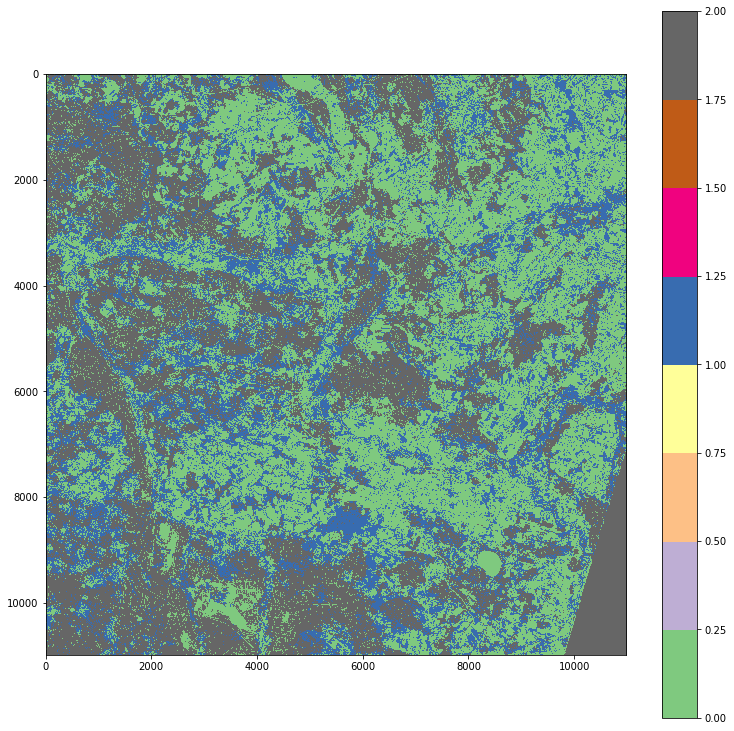

In [25]:
plt.figure(figsize=(13, 13))
plt.imshow(predicted_classes, cmap='Accent')
plt.colorbar()
plt.show()

In [26]:
# 1. Remove non-existing pixles

predicted_classes[base_band == 0] = np.nan
y_test[base_band == 0] = np.nan

In [27]:
# 2. Track errors

error_band = predicted_classes - y_test
error_band[error_band != 0] = 1

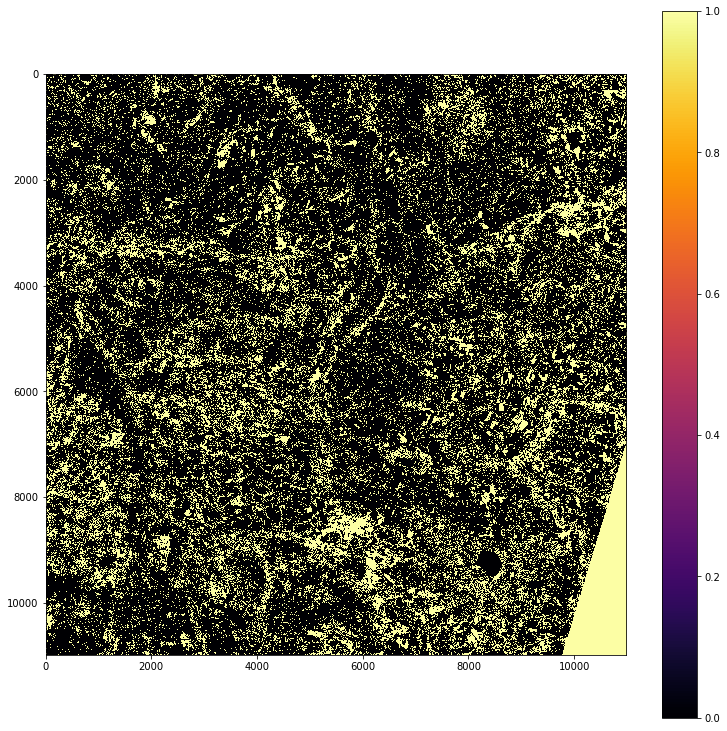

In [28]:
# 3. Visualize errors

plt.figure(figsize=(13, 13))
plt.imshow(error_band, cmap='inferno')
plt.colorbar()
plt.show()

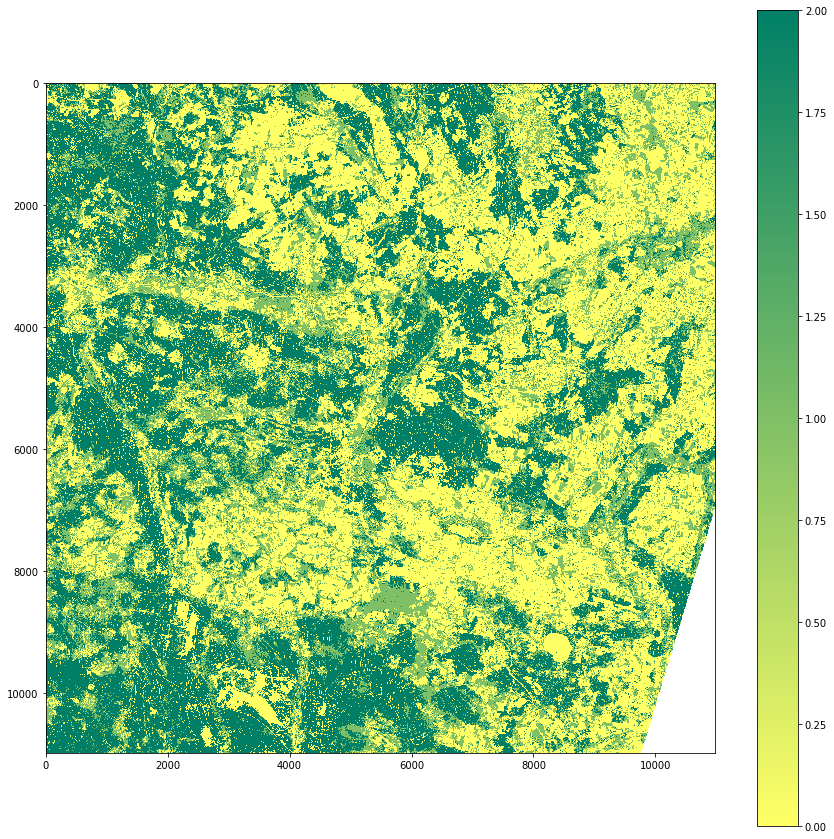

In [29]:
plt.figure(figsize=(15,15))
plt.imshow(predicted_classes, cmap='summer_r')
plt.colorbar()
plt.savefig('classified_forests.png', dpi=600)
plt.show()